In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from habnet.featuriser.featurise import Featuriser, MOL_TYPES
from habnet.featuriser.habnet_featurizer import AtomHAbNetFeaturizer
from chemprop import data, featurizers, nn
from chemprop.nn import metrics
from chemprop.models import multi
from chemprop.nn.metrics import MSE
from lightning import pytorch as pl
from chemprop.featurizers import MorganBinaryFeaturizer

In [3]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv'

# Read in target_data with pandas and then select 'psi_1_dihedral' column and convert the dihedral angles to sin and cos 
import pandas as pd
import numpy as np
# 1 & 2. Load your data
target_df = pd.read_csv(target_data)

# Drop -10 rows in the dihedral angle column
target_df = target_df[target_df['psi_1_dihedral'] != -10]

# 3. Extract the dihedral angles
angles = target_df['psi_1_dihedral']

# 3.1 Remove any -10 rows in the dihedral angle column
angles = angles[angles != -10]
# 3.2 Remove any NaN values
angles = angles.dropna()

# 4. If angles are in degrees, convert to radians
angles_rad = np.deg2rad(angles)

# 5. Compute sin & cos and assign
target_df['psi_1_dihedral_sin'] = np.sin(angles_rad)
target_df['psi_1_dihedral_cos'] = np.cos(angles_rad)

# Optional: inspect
print(target_df[['psi_1_dihedral', 'psi_1_dihedral_sin', 'psi_1_dihedral_cos']].head())



# 6. Save the modified DataFrame back to CSV
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_sin_cos.csv'
target_df.to_csv(target_data, index=False)


# Let's cut it down to rxn,  'psi_1_dihedral_sin', 'psi_1_dihedral_cos'
target_df_slim = target_df[['rxn', 'psi_1_dihedral_sin', 'psi_1_dihedral_cos']]

# Save the modified DataFrame back to CSV
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_slim.csv'
target_df_slim.to_csv(target_data, index=False)


   psi_1_dihedral  psi_1_dihedral_sin  psi_1_dihedral_cos
0      313.550300           -0.724770            0.688991
2      292.580884           -0.923338            0.383987
3      233.012473           -0.798766           -0.601641
4       34.468778            0.565957            0.824435
5      202.755671           -0.386802           -0.922163


In [4]:
feat_data = Featuriser(os.path.expanduser("~/code/chemprop_phd_customised/habnet/data/processed/sdf_data"), 
                       path = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_slim.csv",
                       include_extra_features = False)

Reaction rxn_191 not found in target data
Reaction rmg_rxn_16785 not found in target data
Reaction rxn_1169 not found in target data
Reaction rxn_144 not found in target data
Reaction rmg_rxn_16786 not found in target data
Reaction rxn_1257 not found in target data
Reaction rmg_rxn_1155 not found in target data
Reaction rmg_rxn_1160 not found in target data
Reaction rxn_798 not found in target data
Reaction rxn_682 not found in target data
Reaction rxn_30 not found in target data
Reaction rxn_795 not found in target data
Reaction rxn_111 not found in target data
Reaction rxn_635 not found in target data
Reaction rxn_824 not found in target data
Reaction rxn_182 not found in target data
Reaction rxn_89 not found in target data
Reaction rxn_127 not found in target data
Reaction rxn_286 not found in target data
Reaction rxn_262 not found in target data
Reaction rxn_792 not found in target data
Reaction rxn_909 not found in target data
Reaction rxn_791 not found in target data
Reaction rxn

In [5]:
morgan = MorganBinaryFeaturizer()  # defaults to radius=2, nBits=1024

In [6]:
component_to_split_by = 0
mols = [d.mol for d in feat_data[component_to_split_by]]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "kennard_stone", (0.8, 0.1, 0.1))


train_data, val_data, test_data = data.split_data_by_indices(
    feat_data, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [7]:
from chemprop.featurizers import MorganBinaryFeaturizer
from chemprop import data, featurizers

morgan = MorganBinaryFeaturizer()

def attach_morgan_to_dps(dps):
    new_dps = []
    for dp in dps:
        # pick the mol you actually want to fingerprint:
        mol = dp.mol if not isinstance(dp.mol, tuple) else dp.mol[0]
        new_dp = data.MoleculeDatapoint(
            mol=dp.mol,
            y=dp.y,
            weight=dp.weight,
            gt_mask=dp.gt_mask,
            lt_mask=dp.lt_mask,
            V_f=dp.V_f,
            E_f=dp.E_f,
            V_d=dp.V_d,
            x_d=morgan(mol),       # <-- lowercase x_d
            x_phase=dp.x_phase,
            name=dp.name
        )
        new_dps.append(new_dp)
    return new_dps

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(extra_bond_fdim=0)

train_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(train_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]

val_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(val_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]
test_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(test_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]

In [8]:
train_datasets[0]

MoleculeDataset(data=[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a0980f4c0>, y=[-0.2687813250856759, 0.9632012247112168], weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), x_phase=None, name='rmg_rxn_1563_r1h', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a0984a500>, y=[-0.4177361282149111, -0.9085683943347442], weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0, 1, 0, ..., 0, 0, 0], dtype=uint8), x_phase=None, name='rxn_1786_r1h', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a09841af0>, y=[-0.8384799126339679, 0.5449325060127479], weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), x_phase=None, name='rxn_746_r1h', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a0972d150>, y=[-5.177931384575588e-05, -0.9999999986594512], weight=1.0, gt_mask=None, lt_mask=Non

In [9]:
# featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(

#     extra_bond_fdim=0
# )

# train_datasets = [data.MoleculeDataset(train_data[0][i], featurizer) for i in range(len(MOL_TYPES))]
# val_datasets = [data.MoleculeDataset(val_data[0][i], featurizer) for i in range(len(MOL_TYPES))]
# test_datasets = [data.MoleculeDataset(test_data[0][i], featurizer) for i in range(len(MOL_TYPES))]

In [10]:
train_datasets

[MoleculeDataset(data=[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a0980f4c0>, y=[-0.2687813250856759, 0.9632012247112168], weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), x_phase=None, name='rmg_rxn_1563_r1h', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a0984a500>, y=[-0.4177361282149111, -0.9085683943347442], weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0, 1, 0, ..., 0, 0, 0], dtype=uint8), x_phase=None, name='rxn_1786_r1h', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a09841af0>, y=[-0.8384799126339679, 0.5449325060127479], weight=1.0, gt_mask=None, lt_mask=None, x_d=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), x_phase=None, name='rxn_746_r1h', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x757a0972d150>, y=[-5.177931384575588e-05, -0.9999999986594512], weight=1.0, gt_mask=None, lt_mask=No

In [11]:
train_datasets[0][0].mg.E.shape


(26, 27)

In [12]:
train_datasets[0][0].mg.V.shape

(14, 72)

In [13]:
train_datasets[0][0].y.shape

(2,)

In [14]:
train_mcdset = data.MulticomponentDataset(train_datasets)
train_scales = train_mcdset.normalize_inputs("X_d")


val_mcdset = data.MulticomponentDataset(val_datasets)

test_mcdset = data.MulticomponentDataset(test_datasets)

val_scales   = val_mcdset.normalize_inputs("X_d", scaler=train_scales)
test_scales  = test_mcdset.normalize_inputs("X_d", scaler=train_scales)

In [15]:
train_loader = data.build_dataloader(train_mcdset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=64)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=64)

In [16]:

from chemprop.nn.transforms import ScaleTransform
X_d_scaler = train_scales[0]

# 2) Wrap that into a ScaleTransform:
X_d_transform = ScaleTransform.from_standard_scaler(X_d_scaler)

In [17]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing(depth=6, dropout=0.2
                                  ) for _ in range(len(MOL_TYPES))],
    n_components=len(MOL_TYPES), shared = False    
)


In [18]:
agg = nn.MeanAggregation()

In [19]:
import torch
from torch import Tensor
from chemprop.nn.metrics import ChempropMetric

class CircVectorMSE(ChempropMetric):
    def __init__(self, task_weights=None):
        super().__init__(task_weights=task_weights)

    def _calc_unreduced_loss(self,
                             preds: torch.Tensor,    # (B, 2T)
                             targets: torch.Tensor,  # (B, 2T)
                             mask: torch.Tensor,     # (B, 2T)
                             weights: torch.Tensor,  # (B,) or (B,2T) or (B,T)
                             lt_mask: torch.Tensor,
                             gt_mask: torch.Tensor
                            ) -> torch.Tensor:
        B, out_dim = preds.shape
        T = out_dim // 2

        # reshape preds/targets → (B, T, 2)
        preds   = preds.view(B, T, 2)
        targets = targets.view(B, T, 2)

        # vector‐level mask: require both components valid
        comp_mask = mask.view(B, T, 2).all(dim=-1)  # (B, T)

        # ==== robust weight handling ====
        w = weights
        if w.ndim == 1 and w.numel() == B:
            # per‐sample
            w = w.unsqueeze(1).expand(B, T)
        elif w.ndim == 2 and w.numel() == B * T:
            # already per‐vector
            w = w.view(B, T)
        elif w.ndim == 2 and w.numel() == B * out_dim:
            # per‐component → average to per‐vector
            w = w.view(B, T, 2).mean(dim=-1)
        else:
            # fallback: give every vector the same weight = mean of all
            w = torch.tensor(w.mean(), device=w.device).expand(B, T)
        # =================================

        # compute squared‐error on sin/cos
        se = (preds - targets).pow(2).sum(dim=-1)  # (B, T)

        # apply mask & weights
        return se * comp_mask * w

In [20]:
import torch
import torch.nn.functional as F
from chemprop.nn.metrics import ChempropMetric

class AngularHuberLoss(ChempropMetric):
    """
    Angular Huber loss on degrees. 
    delta: threshold in degrees.
    """
    def __init__(self, delta: float = 10.0, task_weights=None):
        super().__init__(task_weights=task_weights or 1.0)
        self.register_buffer("delta", torch.tensor(delta))

    def _calc_unreduced_loss(self,
                             preds: torch.Tensor,    # (B, T) in degrees
                             targets: torch.Tensor,  # (B, T) in degrees
                             mask: torch.Tensor, 
                             weights: torch.Tensor,
                             lt_mask: torch.Tensor,
                             gt_mask: torch.Tensor) -> torch.Tensor:
        # 1) wrap into [-180,180)
        diff = (preds - targets + 180.0) % 360.0 - 180.0  # (B, T)

        # 2) abs
        abs_d = diff.abs()

        # 3) Huber formula
        delta = self.delta
        quadratic = 0.5 * abs_d**2
        linear    = delta * (abs_d - 0.5*delta)
        loss = torch.where(abs_d <= delta, quadratic, linear)

        # 4) apply mask & weights
        return loss * mask * weights.view_as(loss)

In [21]:
import torch
from torch import Tensor
from chemprop.nn.predictors import RegressionFFN

class PeriodicRegressionFFN(RegressionFFN):
    """
    A RegressionFFN that predicts (sin θ, cos θ) for each task and
    renormalizes to unit length.
    """
    def __init__(
        self,
        input_dim: int = 300,
        hidden_dim: int = 300,
        n_layers: int = 1,
        dropout: float = 0.0,
        activation: str = "relu",
        n_tasks: int = 1,
        criterion=None,
    ):
        # We want 2 outputs per task
        super().__init__(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
            n_tasks=n_tasks * 1,    # double the tasks
            criterion=criterion
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        x: (batch, input_dim)
        returns: (batch, 2 * n_tasks) raw outputs,
                 which we then reshape + normalize.
        """
        raw = self.ffn(x)  # shape (batch, 2 * n_tasks)
        
        B, twoT = raw.shape
        T = twoT // 2
        
        # reshape to (batch, T, 2)
        vecs = raw.view(B, T, 2)
        
        # normalize each 2-vector to unit length
        norms = torch.norm(vecs, dim=-1, keepdim=True).clamp(min=1e-6)
        unit = vecs / norms
        
        # flatten back to (batch, 2*T)
        return unit.view(B, 2 * T)


In [22]:

num_tasks = 2
loss_fn = CircVectorMSE(task_weights=[1.0 for _ in range(num_tasks)])
loss_fn = AngularHuberLoss(delta=5.0, task_weights=[1.0 for _ in range(num_tasks)])
# ffn = nn.RegressionFFN(
#     input_dim=mcmp.output_dim,
#     n_tasks=2,
#     criterion=loss_fn,
# )

ffn = PeriodicRegressionFFN(
    input_dim=mcmp.output_dim + 2048,
    n_tasks=2,
    dropout=0.1,
    n_layers=2
)

In [23]:
metric_list = [metrics.RMSE(), metrics.MAE()] # Only the first metric is used for training and early stopping

In [24]:
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
    warmup_epochs=8,
    max_lr = 5e-4,
    init_lr=5e-5,
    final_lr=1e-5,
    X_d_transform=X_d_transform,
    batch_norm=True

)
mcmpnn



MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=99, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=372, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): PeriodicRegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2648, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=300, out_features=300, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1,

In [25]:
class LossHistoryCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics['train_loss'].cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics['val_loss'].cpu().item())

# 1) Instantiate callback and pass to Trainer
loss_history = LossHistoryCallback()


In [26]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor

# CSVLogger writes metrics.csv under logs/lr_run/
csv_logger = CSVLogger(save_dir="logs/", name="lr_run")
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(
    logger=csv_logger,            # <-- use CSVLogger
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=50,
    # profiler='simple',
    callbacks=[loss_history, lr_monitor],
)
trainer.fit(mcmpnn, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6600') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params | Mode 
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


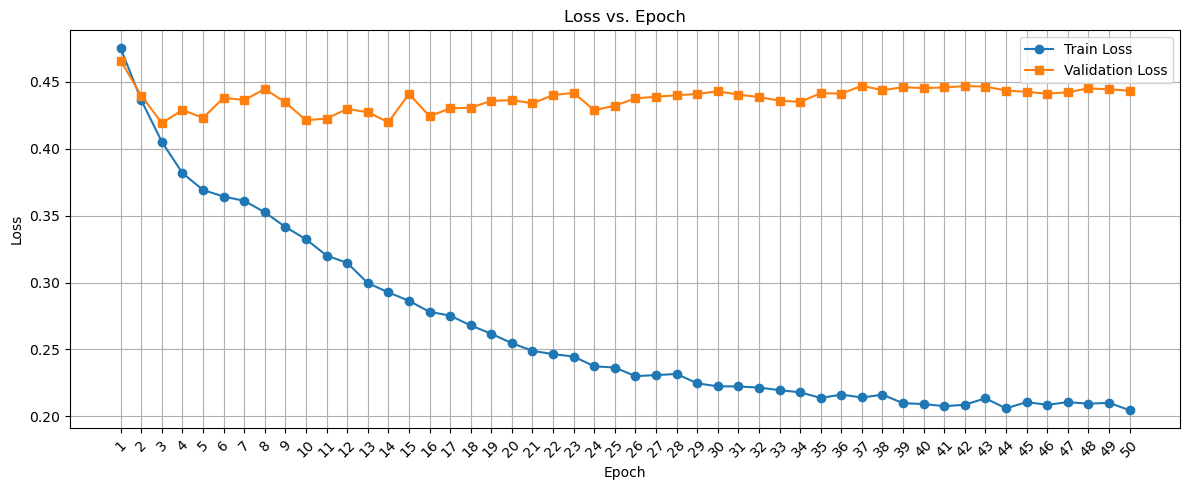

In [30]:
import matplotlib.pyplot as plt

train_losses = loss_history.train_losses         # length 50
# Drop only the first sanity-check entry—keep the final validation after epoch 50
val_losses = loss_history.val_losses[1:]         # now length 50

assert len(train_losses) == len(val_losses), (
    f"Lengths now match: train={len(train_losses)}, val={len(val_losses)}"
)

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses,   label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.xticks(epochs)
# Rotate x-ticks for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3782132/503569672.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['epoch_filled'] = df['epoch'].fillna(method='bfill').astype(int)


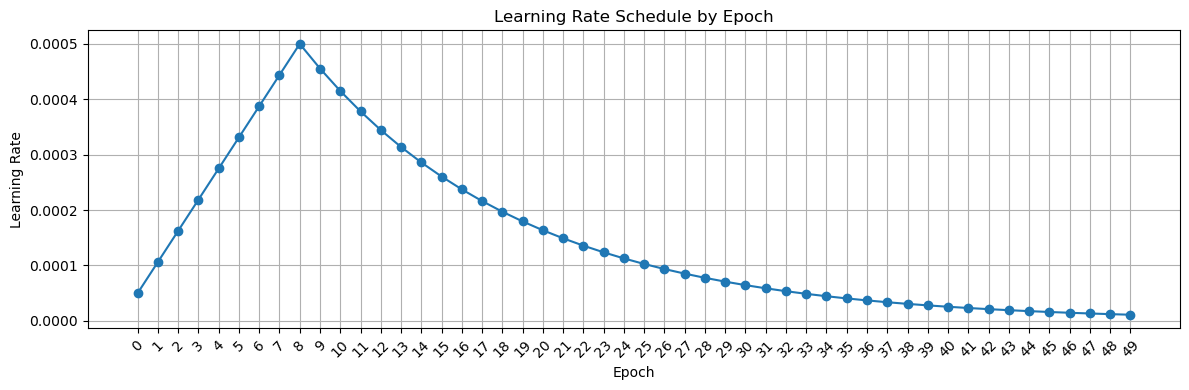

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your CSV
df = pd.read_csv("/home/calvin/code/chemprop_original/logs/lr_run/version_0/metrics.csv")

# 2) Back-fill the epoch column so LR rows pick up the next epoch
df['epoch_filled'] = df['epoch'].fillna(method='bfill').astype(int)

# 3) Filter to only LR rows
lr_df = df[df['lr-Adam'].notna()].copy()

# 4) For each epoch, pick the *first* LR entry (i.e. just after warmup for that epoch)
lr_per_epoch = lr_df.groupby('epoch_filled').first().reset_index()

# 5) Plot LR vs. epoch
plt.figure(figsize=(12,4))
plt.plot(lr_per_epoch['epoch_filled'],
         lr_per_epoch['lr-Adam'],
         marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule by Epoch')
plt.xticks(lr_per_epoch['epoch_filled'])
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import glob
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# 1) Locate the latest TensorBoard event file
# Adjust base_dir if you configured a custom save_dir/name
base_dir = 'lightning_logs'
event_files = glob.glob(f'{base_dir}/**/events.out.tfevents.*', recursive=True)
event_file = sorted(event_files)[-1]

# 2) Load events
ea = event_accumulator.EventAccumulator(event_file, size_guidance={'scalars': 0})
ea.Reload()

# 3) Extract LR scalars
lr_events = ea.Scalars('lr/optimizer0')
steps = [e.step for e in lr_events]
lrs = [e.value for e in lr_events]

# 4) Plot the learning rate schedule
plt.figure(figsize=(8,4))
plt.plot(steps, lrs, marker='o')
plt.xlabel('Optimizer Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule from TensorBoard Logs')
plt.grid(True)
plt.tight_layout()
plt.show()



KeyError: 'Key lr/optimizer0 was not found in Reservoir'

In [ ]:
trainer.test(mcmpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.5524286031723022     │
│         test/rmse         │    0.7529005408287048     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  17951          	

[{'test/rmse': 0.7529005408287048, 'test/mae': 0.5524286031723022}]

In [ ]:
pred = trainer.predict(mcmpnn, test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

PREDICT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  18091        

In [ ]:
preds = torch.cat(pred, dim=0)
sin, cos = preds[:, 0], preds[:, 1]
angles_rad = torch.atan2(sin, cos)

# 3) convert → degrees (optional)
angles_deg = angles_rad * 180.0 / torch.pi
torch.set_printoptions(sci_mode=False, precision=6)
# print("Angles (rad):", angles_rad)
print("Angles (°):", angles_deg)

Angles (°): tensor([    -6.961233,    -15.096138,     59.406895,     13.966700,
           -15.992378,     80.484039,     13.646454,     78.498085,
           -12.314624,      2.514957,    -61.241180,    111.498116,
            16.107319,     23.731934,    125.660538,    171.150238,
           -28.150326,     -1.566404,   -115.881172,     22.873590,
          -129.231583,    -48.130013,     24.353355,    -21.476263,
            -0.551950,     -8.736617,   -105.064331,    119.334305,
            16.341864,    -41.925697,     -5.698689,     41.347755,
            11.434528,    -10.318851,    -12.171529,    -32.479542,
            20.147331,    -12.235094,      4.953975,      5.514770,
            18.318415,   -120.212143,   -132.124176,    -28.727404,
           -15.188784,     37.744205,    -47.293812,    -21.231920,
           -35.355339,    -22.224600,     61.950180,    -20.504768,
           107.372215,    161.872818,      9.241345,     19.713491,
            70.685234,     44.316616

In [ ]:
# Get the true values
true = [test_data[0][0][i].y for i in range(len(test_data[0][0]))]
true_sin = [true[i][0] for i in range(len(true))]
true_cos = [true[i][1] for i in range(len(true))]
true_angles_rad = torch.atan2(torch.tensor(true_sin), torch.tensor(true_cos))
# 3) convert → degrees (optional)
true_angles_deg = true_angles_rad * 180.0 / torch.pi
# print("True Angles (rad):", true_angles_rad)
print("True Angles (°):", true_angles_deg)

True Angles (°): tensor([   -16.657230,     62.466217,      5.530820,     -0.018678,
           -44.088200,    -68.295013,   -155.209290,     22.114275,
            -3.447339,     76.753754,    178.796417,    173.543854,
          -131.389038,     99.694611,    129.951767,    -21.629797,
           132.859970,     12.452434,   -176.154602,    -98.383530,
           -69.119057,    110.716194,   -179.968277,    -50.695091,
           -90.951187,    -59.186825,    -52.369331,    -72.545555,
             0.015396,     -8.895527,     -0.010200,    179.980316,
          -161.556778,     -7.329934,     10.754483,      0.718187,
          -179.978897,    -62.345314,      0.019841,     35.656830,
             0.131538,     -4.144900,   -143.205246,    -79.327721,
           -52.205666,   -179.985565,    -55.634956,     61.591274,
           -85.871056,     -0.142244,    179.422150,      3.311773,
            77.466248,    -99.200562,    -54.584698,    -52.820816,
            54.488205,     33.7

In [ ]:
import torch

# Assuming angles_deg and true_angles_deg are defined as torch tensors from previous code
# Example:
# angles_deg = torch.tensor([...])  # predicted angles in degrees
# true_angles_deg = torch.tensor([...])  # true angles in degrees

# Compute difference and wrap to [-180, 180)
delta = (angles_deg - true_angles_deg + 180) % 360 - 180

# Mean Absolute Angular Error
maae = torch.mean(torch.abs(delta))

# Print result
print(f"Mean Absolute Angular Error (MAAE): {maae:.4f}°")

Mean Absolute Angular Error (MAAE): 56.6810°


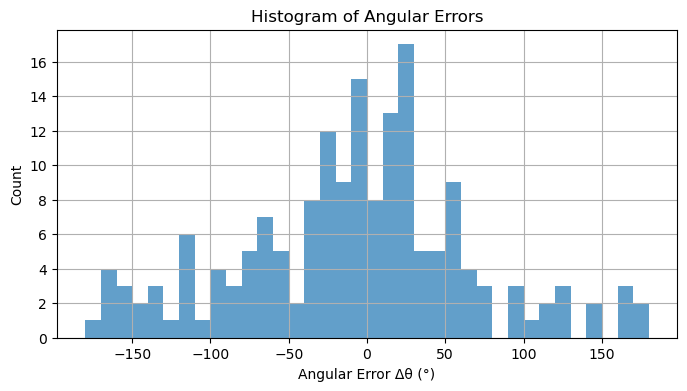

In [ ]:
# delta computed as before
import matplotlib.pyplot as plt
delta = (angles_deg - true_angles_deg + 180) % 360 - 180

plt.figure(figsize=(8,4))
plt.hist(delta.numpy(), bins=36, range=(-180,180), alpha=0.7)
plt.xlabel('Angular Error Δθ (°)')
plt.ylabel('Count')
plt.title('Histogram of Angular Errors')
plt.grid(True)
plt.show()

In [ ]:
# true_angles_deg is your torch tensor
baseline_delta = (0.0 - true_angles_deg + 180) % 360 - 180
baseline_maae = torch.mean(torch.abs(baseline_delta))
print(f"Zero‐predictor MAAE = {baseline_maae:.1f}°")


Zero‐predictor MAAE = 63.6°


In [ ]:
import torch

# angles_deg, true_angles_deg: your existing tensors of shape (N,), in degrees.

# 1) Compute signed differences, wrapped into (−180,180]:
delta = (angles_deg - true_angles_deg + 180) % 360 - 180

# 2) Mean bias
bias = torch.mean(delta)  
print(f"Mean signed error (bias): {bias:.2f}°")

# 3) Apply bias correction to predictions
angles_corrected = (angles_deg - bias + 180) % 360 - 180

# 4) Compute corrected MAAE
delta_corr = (angles_corrected - true_angles_deg + 180) % 360 - 180
maae_corr = torch.mean(torch.abs(delta_corr))
print(f"Bias-corrected MAAE: {maae_corr:.2f}°")


Mean signed error (bias): -7.83°
Bias-corrected MAAE: 56.91°


R^2 = -0.0741


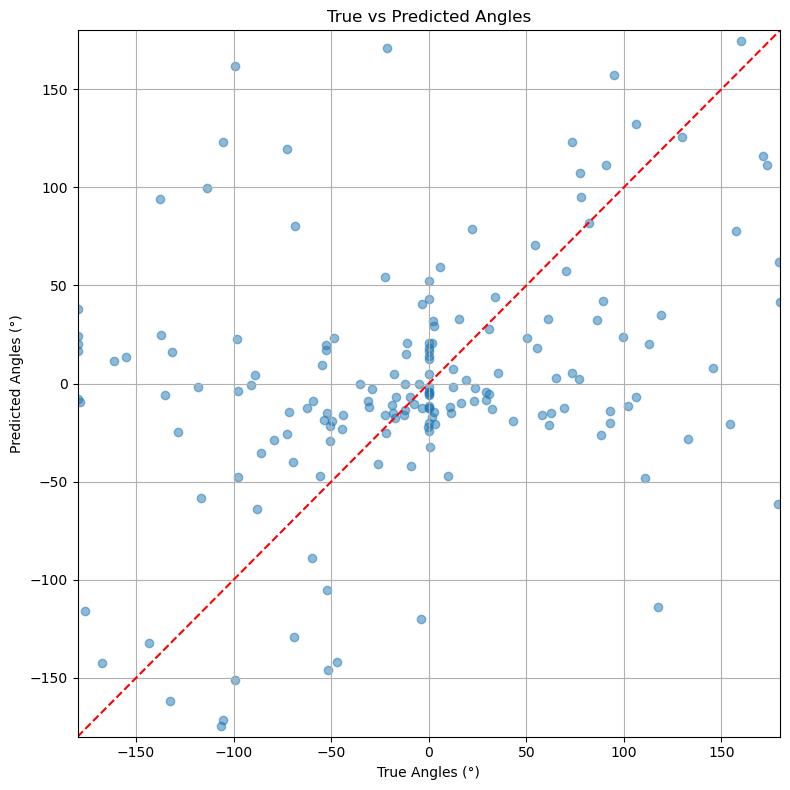

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1) Disable scientific notation and set precision
torch.set_printoptions(sci_mode=False, precision=6)
import torch

# mean of true
y_bar = torch.mean(true_angles_deg)
ss_tot = torch.sum((true_angles_deg - y_bar)**2)
ss_res = torch.sum((true_angles_deg - angles_deg)**2)
r2_torch = 1 - ss_res / ss_tot
print(f"R^2 = {r2_torch:.4f}")


# # 2) Print arrays
# print("Predicted Angles (°):", angles_deg)
# print("True Angles (°):", true_angles_deg)

# 3) Plot without seaborn
plt.figure(figsize=(8, 8))
plt.scatter(true_angles_deg.numpy(), angles_deg.numpy(), alpha=0.5)
plt.plot([-180, 180], [-180, 180], 'r--')  # identity line y=x
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel('True Angles (°)')
plt.ylabel('Predicted Angles (°)')
plt.title('True vs Predicted Angles')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import torch
from chemprop.nn.metrics import ChempropMetric

# Define the custom loss class
class CircVectorMSE(ChempropMetric):
    def __init__(self, task_weights=None):
        super().__init__(task_weights=task_weights)

    def _calc_unreduced_loss(self, preds, targets, mask, weights, lt_mask, gt_mask):
        B, out_dim = preds.shape
        T = out_dim // 2

        preds = preds.view(B, T, 2)
        targets = targets.view(B, T, 2)
        comp_mask = mask.view(B, T, 2).all(dim=-1)

        # Handle weights
        w = weights
        if w.ndim == 1 and w.numel() == B:
            w = w.unsqueeze(1).expand(B, T)
        elif w.ndim == 2 and w.numel() == B * T:
            w = w.view(B, T)
        elif w.ndim == 2 and w.numel() == B * out_dim:
            w = w.view(B, T, 2).mean(dim=-1)
        else:
            w = torch.tensor(w.mean(), device=w.device).expand(B, T)

        se = (preds - targets).pow(2).sum(dim=-1)
        return se * comp_mask * w

# Instantiate the loss metric
loss_fn = CircVectorMSE(task_weights=[1.0 for _ in range(num_tasks)])

# Create test data
# Batch of 2, 1 task each -> output dim = 2
# Case 1: perfect prediction => zero loss
# Case 2: prediction off by 90° => sin difference = 1, cos difference = 1 => loss = 1^2 + 1^2 = 2
preds = torch.tensor([[0.0, 1.0], [1.0, 0.0]], dtype=torch.float32)  # [sin, cos]
targets = torch.tensor([[0.0, 1.0], [0.0, 1.0]], dtype=torch.float32)
mask = torch.ones_like(preds, dtype=torch.bool)
weights = torch.ones(preds.size(0))  # per-sample weights

# Compute unreduced loss (batch, tasks)
unreduced = loss_fn._calc_unreduced_loss(preds, targets, mask, weights, None, None)

print("Unreduced loss per (batch, task):")
print(unreduced)

# Sum to scalar (Chemprop would do this internally)
total_loss = unreduced.sum()
print("\nTotal loss:", total_loss.item())


Unreduced loss per (batch, task):
tensor([[0.],
        [2.]])

Total loss: 2.0
